In [2]:
import numpy as np
import scipy.io as sio

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
torch.__version__

'1.3.1'

Data

In [2]:
qpsk_data = sio.loadmat("./data/qpsk_data.mat")["data"]
qpsk_data.shape

(512, 1024)

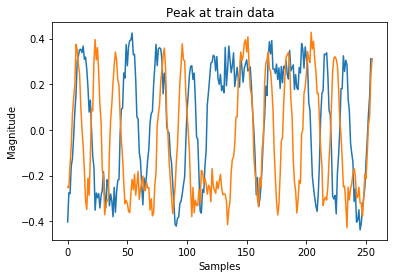

In [3]:
plt.plot(qpsk_data[0,:256].real)
plt.plot(qpsk_data[0,:256].imag)
plt.title('Peak at train data')
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.show()

In [4]:
# preallocate
x = np.array([]).reshape((0,1024,2))
y = np.array([])

In [5]:
for i, name in enumerate(os.listdir("./data")):
    mod_data = sio.loadmat("./data/"+name)["data"]
    mod_data = np.dstack((mod_data.real, mod_data.imag))
    x = np.concatenate((x, mod_data), axis=0)
    y = np.concatenate((y, np.ones(mod_data.shape[0],)*i))

In [6]:
x = np.expand_dims(x, axis=3)

In [7]:
x.shape

(2048, 1024, 2, 1)

In [8]:
x = np.transpose(x, (0,3,2,1))

In [9]:
x = torch.tensor(x).float()
y = torch.tensor(y).long()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [11]:
dataset = torch.utils.data.TensorDataset(x_train, y_train)

In [12]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Model

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (2,16))
        self.conv2 = nn.Conv2d(8, 4, (1,16))
        
        self.fc1 = nn.Linear(994*4, 120) # width after filters * num output filters
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [25]:
num_epochs = 5

losses = np.zeros(num_epochs,)
val_losses = np.zeros(num_epochs,)

for epoch in range(num_epochs):  # loop over the dataset multiple times

#     net.train()
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 16 == 15:    # print every 16 mini-batches
    print('Epoch {}: loss {}'.format(epoch + 1, running_loss/i))
            
    losses[epoch] = running_loss/i # divide by final num of iterations
    
    # validation
    with torch.no_grad():
        outputs = net(x_test)
        val_losses[epoch] = criterion(outputs, y_test).item()
    

print('Finished Training')

Epoch 1: loss 1.084444727383408
Epoch 2: loss 0.564906692388011
Epoch 3: loss 0.17519909968855335
Epoch 4: loss 0.04099372372615571
Epoch 5: loss 0.007129226331872975
Finished Training


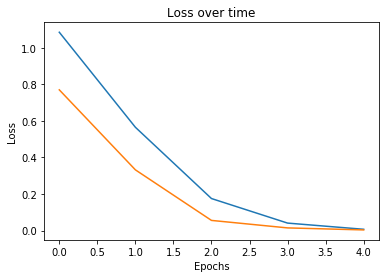

In [26]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss over time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()